In [36]:
from sklearn.datasets import load_wine, make_blobs,make_classification
import matplotlib.pyplot as plt
import cvxopt
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from sklearn import preprocessing
from sklearn.svm import OneClassSVM
from scipy import linalg
from sklearn.metrics.pairwise import rbf_kernel, polynomial_kernel, laplacian_kernel, sigmoid_kernel, linear_kernel

In [80]:
#loading wine datasets and blob dataset

x_wine = load_wine()['data'][:, [1, 2]]
x_wine2 = load_wine()['data'][:, [6, 9]] 
x_blob, y = make_blobs(n_samples=[10,100], n_features=2, cluster_std=1,centers= [(2,3), (2.5,3.5)])

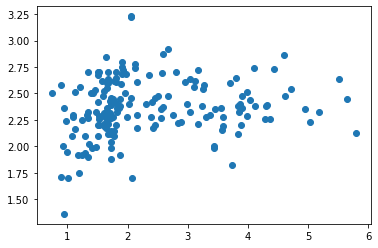

In [94]:
# to save the visualisations of datasets
plt.scatter(x_wine[:,0],x_wine[:,1])
plt.savefig("original xwine", bbox_inches='tight',dpi = 200)

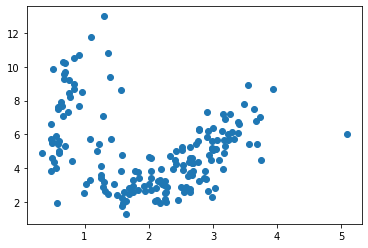

In [95]:
plt.scatter(x_wine2[:,0],x_wine2[:,1])
plt.savefig("original xwine2", bbox_inches='tight',dpi = 200)

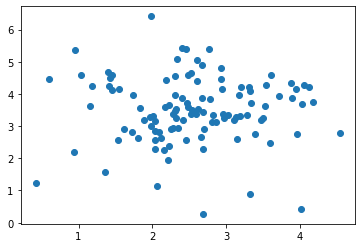

In [96]:
plt.scatter(x_blob[:,0],x_blob[:,1])
plt.savefig("original xblob", bbox_inches='tight',dpi = 200)

In [206]:
#solver using the python library CVXOPT

def qp(P, q, A, b, C):
    n = P.shape[0]
    P = cvxopt.matrix(P)
    q = cvxopt.matrix(q)
    A = cvxopt.matrix(A)
    b = cvxopt.matrix(b)
    G = cvxopt.matrix(np.concatenate(
        [np.diag(np.ones(n) * -1), np.diag(np.ones(n))], axis=0))
    h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))
    cvxopt.solvers.options['show_progress']=False
    solution = cvxopt.solvers.qp(P, q, G, h, A, b, solver='mosec')
    return np.ravel(solution['x'])

def ocsvm_solver(K, nu=0.1):
    n = len(K)
    P = K
    q = np.zeros(n)
    A = np.matrix(np.ones(n))
    b = 1.
    C = 1. / (nu * n)
    mu = qp(P, q, A, b, C)
    idx_support = np.where(np.abs(mu) > 1e-5)[0]
    mu_support = mu[idx_support]
    return mu_support, idx_support

def rho(K, mu_support, idx_support):
    index = int(np.argmin(mu_support))
    K_support = K[idx_support][:, idx_support]
    rho1 = mu_support.dot(K_support[index])
    return rho1

In [226]:
#function to plot

def plot(X, mu_support, idx_support, rho,kernel,gamma):
    X1, X2 = np.meshgrid(np.linspace(0, 6, 500), np.linspace(0, 6, 500))
    na, nb = X1.shape
    X_test = np.c_[np.reshape(X1, (na * nb, 1)),
                   np.reshape(X2, (na * nb, 1))]

    X_support = X[idx_support]
    if kernel == "RBF":
        K = rbf_kernel(X_test, X_support,gamma=gamma)
    elif kernel == "Polynomial":
        K = polynomial_kernel(X_test, X_support,gamma=gamma)
    elif kernel == "Sigmoid":
        K = sigmoid_kernel(X_test, X_support,gamma=gamma)
    elif kernel == "Laplacian":
        K = laplacian_kernel(X_test, X_support,gamma=gamma)
    elif kernel == "Linear":
        K = linear_kernel(X_test, X_support)

    decision = K.dot(mu_support) - rho
    y_pred = np.sign(decision)

    # Plot
    plt.scatter(X[:,0], X[:, 1], linewidth=2)
    Z = np.reshape(decision, (na, nb))
    plt.contour(X1, X2, Z,[0], linewidths=2, zorder=10,colors="red")

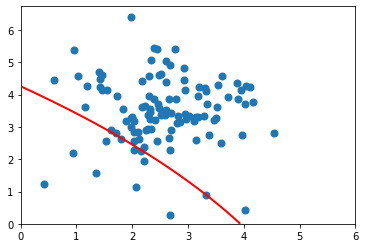

In [230]:
#to perform experiments

def ocsvm(x,kernel,gamma,nuu=0.1):
    if kernel == "RBF":
        K = rbf_kernel(x,gamma=gamma)
    elif kernel == "Polynomial":
        K = polynomial_kernel(x,gamma=gamma)
    elif kernel == "Sigmoid":
        K = sigmoid_kernel(x,gamma=gamma)
    elif kernel == "Laplacian":
        K = laplacian_kernel(x,gamma=gamma)
    elif kernel == "Linear":
        K = linear_kernel(x)
        
    mu_support, idx_support = ocsvm_solver(K, nu=nuu)
    rho1 = rho(K, mu_support, idx_support)
    plot(x, mu_support, idx_support, rho1,kernel,gamma)
    plt.savefig("blob poly", bbox_inches='tight',dpi = 200)
    
#test
ocsvm(x_blob,"Polynomial",2,0.1)